# Apply RVAE for FashionMNIST data set
* <b>Objective:</b> In this problem, the purpose is trian a robust varational autoencoder when the training is polluted with outliers. Here we chose shoes and sneakers as inliers classes and samples from other categories as outliers. Since these images contain a significant range of gray scales, we chose the Gaussian model. 

In [18]:
from __future__ import print_function
import argparse
import torch
import math
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import fashion_mnist
import scipy.io as spio
import os
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Define parameters
seed:random seed 
epochs:number of epochs
CODE_SIZE: z dimention
SIGMA:constant variance for Guassian loss function
batch_size:batch size for training
log_interval:how many batches to wait before logging training status

In [19]:
seed = 10004
epochs = 150 
batch_size = 120
log_interval = 10
CODE_SIZE = 20
SIGMA = 0.5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Creat data for test loader and train loader
input: anomoly percentage
output: train_loader, test_loader

In [20]:
def create_data(frac_anom):

    torch.manual_seed(seed=seed)
    np.random.seed(seed=seed)

    (X, X_lab), (_test_images, _test_lab) = fashion_mnist.load_data()
    X_lab = np.array(X_lab)

    # find other categories
    ind = np.isin(X_lab, (0, 1, 2, 3, 4, 5, 6, 8))  #(1, 5, 7, 9)
    X_lab_outliers = X_lab[ind]
    X_outliers = X[ind]

    # find sneaker and ankle boots
    ind = np.isin(X_lab, (7, 9))  # (0, 2, 3, 4, 6))  #
    X_lab = X_lab[ind]
    X = X[ind]

    #normalize the data
    X = X / 255.0
    X_outliers = X_outliers / 255.0

    # add ouliers to the data the label for outliers is 10
    Nsamp = np.int(np.rint(len(X) * frac_anom)) + 1
    X[:Nsamp, :, :] = X_outliers[:Nsamp, :, :]
    X_lab[:Nsamp] = 10

    #split data to train and test
    X_train, X_test, X_lab_train, X_lab_test = train_test_split(
        X, X_lab, test_size=0.33, random_state=10003)
    X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
    X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))


    
    #append samples and labels
    train_data = []
    for i in range(len(X_train)):
        train_data.append(
            [torch.from_numpy(X_train[i]).float(), X_lab_train[i]])

    test_data = []
    for i in range(len(X_test)):
        test_data.append(
            [torch.from_numpy(X_test[i]).float(), X_lab_test[i]])
        
        
    #generate train loader and test loader
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=len(test_data),
                                              shuffle=False)

    return train_loader, test_loader

# Define MSE loss and beta loss for Guassian posterior


In [21]:
#MSE loss
def MSE_loss(Y, X):
    ret = (X - Y)**2
    ret = torch.sum(ret)
    return ret

#beta loss
def SE_loss(Y,X):
    ret = (X - Y)**2
    ret = torch.sum(ret,1)
    return ret
    
def Gaussian_CE_loss(Y, X, beta, sigma=SIGMA):  # 784 for mnist
    Dim = Y.shape[1]
    const1 = -((1 + beta) / beta)
    const2 = 1 / pow((2 * math.pi * (sigma**2)), (beta * Dim / 2))
    SE = SE_loss(Y, X)
    term1 = torch.exp(-(beta / (2 * (sigma**2))) * SE)
    loss = torch.sum(const1 * (const2* term1 - 1))
    return loss


def beta_loss_function(recon_x, x, mu, logvar, beta):

    if beta > 0:
        # If beta is nonzero, use the beta entropy
        BBCE = Gaussian_CE_loss(recon_x.view(-1, 784), x.view(-1, 784), beta)
    else:
        # if beta is zero use binary cross entropy
        BBCE = MSE_loss(recon_x.view(-1, 784), x.view(-1, 784))

    # compute KL divergence
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BBCE + KLD

# Define network

In [22]:
class RVAE(nn.Module):
    def __init__(self):
        super(RVAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, CODE_SIZE)
        self.fc22 = nn.Linear(400, CODE_SIZE)
        self.fc3 = nn.Linear(CODE_SIZE, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    
    # for reseting network weights
    def weight_reset(self):

        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                m.reset_parameters()

# Define model reset
This function calls weight_reset from the network class and reset the weights of the network.

In [23]:
def model_reset():
    model.weight_reset()

# Define model and optimizer

In [24]:
model = RVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training function
input: number of epochs, value of beta

Prints loss after each log intervalof bathces and after each epoch

In [30]:
def train(epoch, beta_val):
    model.train()
    train_loss = 0
    for batch_idx, (data, data_lab) in enumerate(train_loader):
   
        data = (data).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = beta_loss_function(recon_batch, data, mu, logvar, beta=beta_val)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % log_interval == 0 and epoch % 150 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    #print('====> Epoch: {} Average loss: {:.4f}'.format(
        #epoch, train_loss / len(train_loader.dataset)))

# Testing function
input: number of epochs, value of beta
out put: total loss for the test samples, loss for the inlier samples in the test, loss for the out lier samples in the test
Saves the resconstruction of 8 random samples(4 inliers, 4 outliers)
Saves data, reconstruction and anomolies lables in a npz file

In [31]:
def test(frac_anom, beta_val):
    model.eval()
    test_loss_total = 0
    test_loss_anom = 0
    num_anom = 0
    with torch.no_grad():
        for i, (data, data_lab) in enumerate(test_loader):
        
            data = (data).to(device)
            recon_batch, mu, logvar = model(data)
            anom_lab = data_lab == 10
            num_anom += np.sum(anom_lab.numpy())  # count number of anomalies
            anom_lab = (anom_lab[:, None].float()).to(device)

            test_loss_anom += MSE_loss(recon_batch * anom_lab,
                                      data * anom_lab).item()
            test_loss_total += MSE_loss(recon_batch, data).item()

            if i == 0:
                n = min(data.size(0), 100)
                samp=[4, 14, 50, 60, 25, 29, 32, 65]
                comparison = torch.cat([
                    data.view(len(recon_batch), 1, 28, 28)[samp],
                    recon_batch.view(len(recon_batch), 1, 28, 28)[samp]
                ])
                save_image(comparison.cpu(),
                           'results/fashion_mnist_recon_shallow_' +
                           str(beta_val) + '_' + str(frac_anom) + '.png',
                           nrow=n)

        np.savez('results/fashion_mnist_' + str(beta_val) + '_' +
                 str(frac_anom) + '.npz',
                 recon=recon_batch.cpu(),
                 data=data.cpu(),
                 anom_lab=anom_lab.cpu())

    test_loss_normals = (test_loss_total - test_loss_anom) / (
        len(test_loader.dataset) - num_anom)
    test_loss_anom /= num_anom
    test_loss_total /= len(test_loader.dataset)

    print('====> Test set loss: {:.4f}'.format(test_loss_total))

    return test_loss_total, test_loss_anom, test_loss_normals


# Main function

Runs training and testing for a givern values of beta and percentage of anomolies

In [32]:
if __name__ == "__main__":

    brange=[0,0.01]
    erange = range(1, epochs + 1)
    anrange = np.array([0.01,0.05,0.1])
    
    test_loss_total = np.zeros((len(anrange), len(brange)))
    test_loss_anom = np.zeros((len(anrange), len(brange)))
    test_loss_normals = np.zeros((len(anrange), len(brange)))

    for b, betaval in enumerate(brange):

        for a, frac_anom in enumerate(anrange):
            train_loader, test_loader = create_data(frac_anom)
            model_reset()
            for epoch in erange:

                train(epoch, beta_val=betaval)

            print('epoch: %d, beta=%g, frac_anom=%g' %
                      (epoch, betaval, frac_anom))

            # save the model
            torch.save(model, 'results/fashion_mnist_beta_shallow_' + str(betaval) + '_frac_anom_' + str(frac_anom))

            test_loss_total[a, b], test_loss_anom[a, b], test_loss_normals[
                a, b] = test(frac_anom, beta_val=betaval)



        np.savez('results/test_loss_fashionmnist_beta_shallow' + str(b) + '.npz',
                 test_loss_total=test_loss_total,
                 test_loss_anom=test_loss_anom,
                 test_loss_normals=test_loss_normals,
                 brange=brange,
                 anrange=anrange)


Train Epoch: 150 [0/8040 (0%)]	Loss: 18.710547
Train Epoch: 150 [1200/8040 (15%)]	Loss: 18.593837
Train Epoch: 150 [2400/8040 (30%)]	Loss: 18.170333
Train Epoch: 150 [3600/8040 (45%)]	Loss: 17.934473
Train Epoch: 150 [4800/8040 (60%)]	Loss: 18.242550
Train Epoch: 150 [6000/8040 (75%)]	Loss: 18.065548
Train Epoch: 150 [7200/8040 (90%)]	Loss: 18.883134
epoch: 150, beta=0, frac_anom=0.01
====> Test set loss: 13.3175
Train Epoch: 150 [0/8040 (0%)]	Loss: 19.305750
Train Epoch: 150 [1200/8040 (15%)]	Loss: 19.701449
Train Epoch: 150 [2400/8040 (30%)]	Loss: 18.166032
Train Epoch: 150 [3600/8040 (45%)]	Loss: 18.264591
Train Epoch: 150 [4800/8040 (60%)]	Loss: 18.486597
Train Epoch: 150 [6000/8040 (75%)]	Loss: 18.675830
Train Epoch: 150 [7200/8040 (90%)]	Loss: 19.026428
epoch: 150, beta=0, frac_anom=0.05
====> Test set loss: 13.5712
Train Epoch: 150 [0/8040 (0%)]	Loss: 19.972017
Train Epoch: 150 [1200/8040 (15%)]	Loss: 20.041073
Train Epoch: 150 [2400/8040 (30%)]	Loss: 18.720496
Train Epoch: 150 

# VAE reconstruction with 10% outlier

First 6 samples are inputs and the second 10 samples are the reconstructions

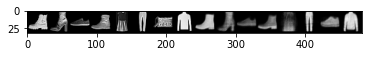

In [33]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('results/fashion_mnist_recon_shallow_0_0.1.png')
imgplot = plt.imshow(img)
plt.show()

# RVAE reconstruction with 10% outlier

First 6 samples are inputs and the second 10 samples are the reconstructions

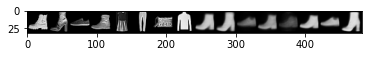

In [34]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('results/fashion_mnist_recon_shallow_0.01_0.1.png')
imgplot = plt.imshow(img)
plt.show()

# Colors and legends for ROC


In [35]:
cwd = os.getcwd()

FPRs = dict()
TPRs = dict()
AUC = dict()

lgd = {
    0: 'VAE-1%',
    1: 'VAE-5%',
    2: 'VAE-10%',
    3: 'RVAE-1%',
    4: 'RVAE-5%',
    5: 'RVAE-10%'
}
colors = {0: 'r', 1: 'b', 2: 'k', 3: 'r', 4: 'b', 5: 'k'}
lsty = {0: '--', 1: '--', 2: '--', 3: '-', 4: '-', 5: '-'}
c = 0

# Calculate ROC and AUC

In [36]:
for beta in brange:
    for frac in anrange:
  
        if beta == 0:
            beta_str = f"{beta:.0f}"
        else:
            beta_str = str(beta)

        filename = cwd + '/results/fashion_mnist_' + beta_str + '_' + str(
            frac) + '.npz'
   

        s = np.load(filename)

        y = s['recon']
        x = s['data']
        L = s['anom_lab']

        y = y.reshape(y.shape[0], -1)
        x = x.reshape(x.shape[0], -1)
        L = L.reshape(L.shape[0], -1)

        mse = np.linalg.norm(x - y, 2, 1, True)
        fpr, tpr, _ = roc_curve(L, mse)
        auc = roc_auc_score(L,mse)

        FPRs[c] = fpr
        TPRs[c] = tpr
        AUC[c] = auc

        c = c + 1

# Plot ROC

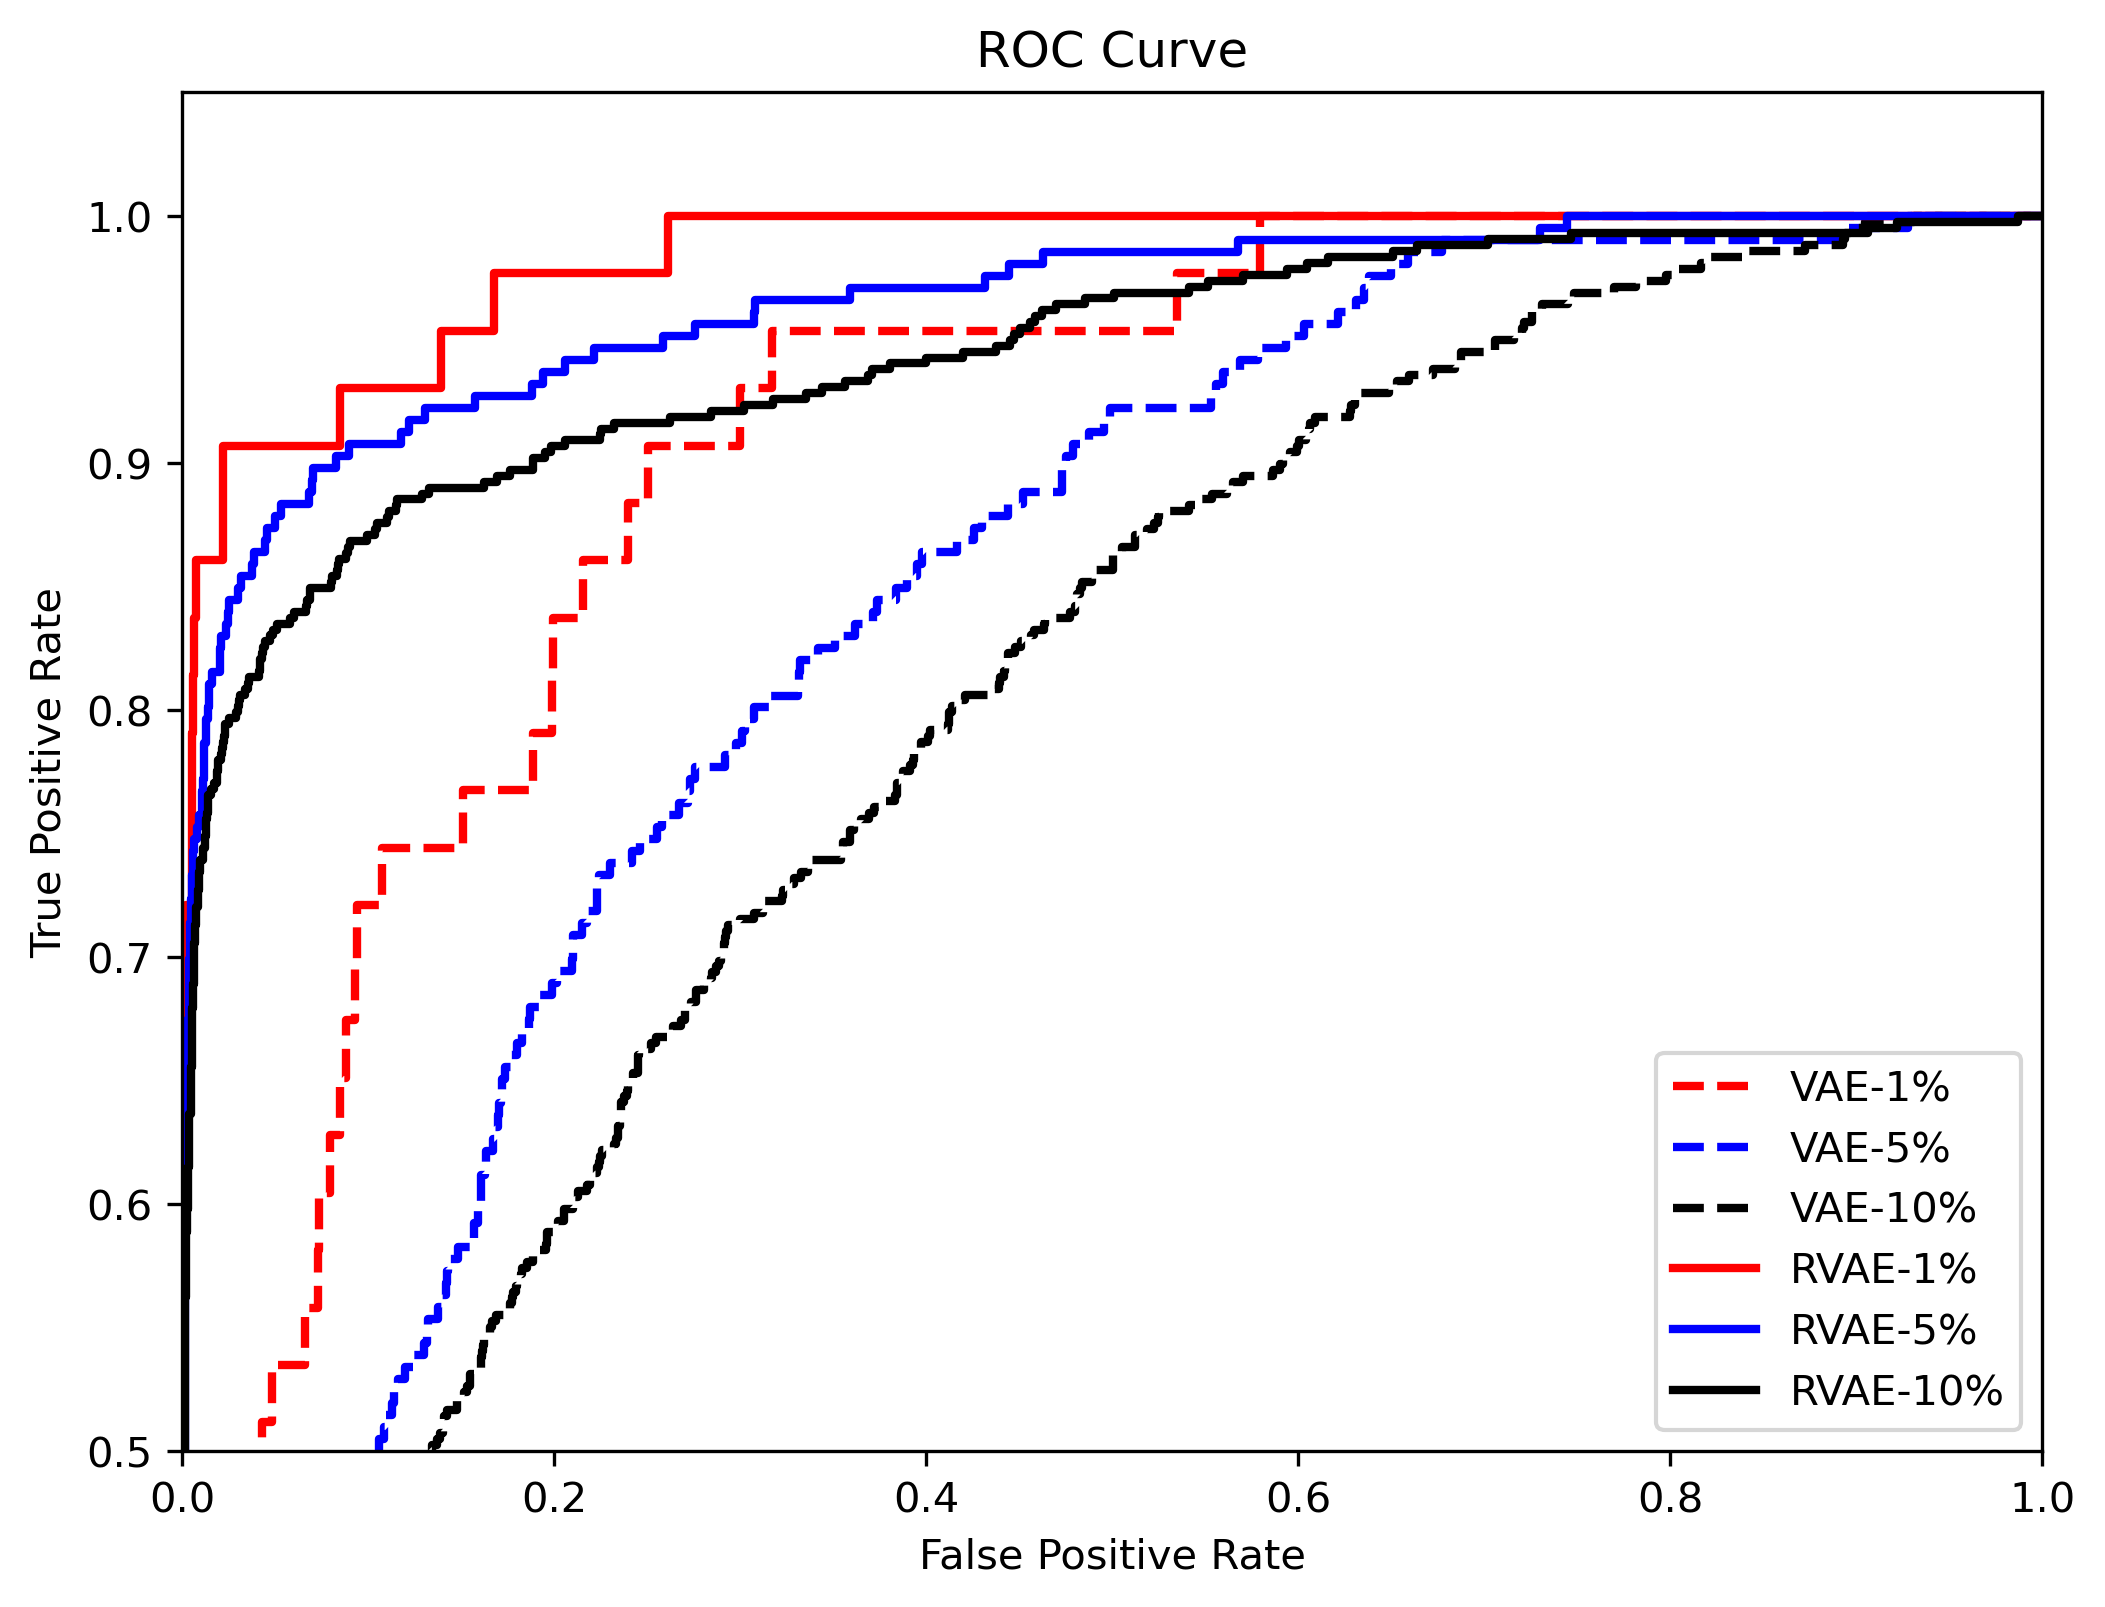

AUC is {0: 0.898848786743533, 1: 0.8256978963539217, 2: 0.7807364260453507, 3: 0.9827288325783258, 4: 0.9640344797264795, 5: 0.9434854203420876}


In [38]:
lw = 2
fig = plt.figure(figsize=(8, 6), dpi=300)
for c in np.arange(0, len(FPRs)):
    fpr = FPRs[c]
    tpr = TPRs[c]

    plt.plot(fpr, tpr, lsty[c], color=colors[c], lw=lw, label=lgd[c])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')


plt.xlim([0.0, 1.0])
plt.ylim([0.5, 1.05])
plt.legend()
plt.show()

fig.savefig('results/ROCn_fashion_mnist.png')

print('AUC is' , AUC)